<font style="font-size:96px; font-weight:bolder; color:#0040a0"><img src="http://montage.ipac.caltech.edu/docs/M51_logo.png" alt="M" style="float: left; padding: 25px 30px 25px 0px;" /></font>

<i><b>Montage</b> is a general astronomical image toolkit with facilities for reprojection, background matching, mosacking and visualization.  It can be used as a set of command-line tools (Linux, OS X and Windows), C library calls (Linux and OS X) and as Python binary extension modules.</i>
    
<i>Montage source code can be downloaded from GitHub ( https://github.com/Caltech-IPAC/Montage ).  The Python package can be installed from PyPI ("pip install MontagePy"). See
http://montage.ipac.caltech.edu/ for more information.</i>

# MontagePy.main modules: mArchiveGet

A large percentage of the Montage modules focus on processing a set of images (often retrieved from a mission archive); projecting them to a common frame, adjusting their background levels as a set, and coadding them into a mosaic.

This page is focused on the details of one of these modules: mArchiveGet.  For a broader context, please see <a href="Mosaic.ipynb">Building a Mosaic with Montage</a> or the <a href="Mosaic_oneshot.ipynb"> one shot </a> version if you just want to see the commands.


<b>Note:</b> The MontagePy python package has no external dependencies. We include other utilities on this page to aid in visualizing MontagePy package results.


## mArchiveGet Python Help


In [1]:
from MontagePy.main import mArchiveGet, mViewer

help(mArchiveGet)


Help on built-in function mArchiveGet in module MontagePy.main:

mArchiveGet(...)
    mArchiveGet retrieves an image file by URL from one of several archives.
    
    Parameters
    ----------
    url : str
        Directory containing files to be coadded.
    datafile : str
        Table file list of reprojected files to coadded.
    timeout : int, optional
        Timeout in seconds.
    debug : int, optional
        Debugging output level.
    
    
    Returns
    -------
    status : int
        Return status (0: OK, 1:ERROR).
    msg : str
        Return message (for errors).
    count : int
        Size of file in bytes.



## mArchiveGet Example

mArchiveGet can be used stand-alone but is really just meant for use by mArchiveExec when retreiving a list of images.  Stand-alone it has no advantage over tools like wget and curl.  The two main arguments are the URL to retreive and the local file to write it to:


In [2]:
rtn = mArchiveGet('http://irsa.ipac.caltech.edu/ibe/data/twomass/full/full/990502s/s134/image/ji1340186.fits.gz', 
                  'work/M17/raw/2mass-atlas-990502s-j1340186.fits')

print(rtn)


{'status': '0', 'count': 1633635}


Montage modules return JSON structures.  They always include a status (0: success; 1: error) and a variable number of informational parameters.  Here the returned file had 1633635 bytes.


## Returned Data

To verify the download, we can take a look at the image:

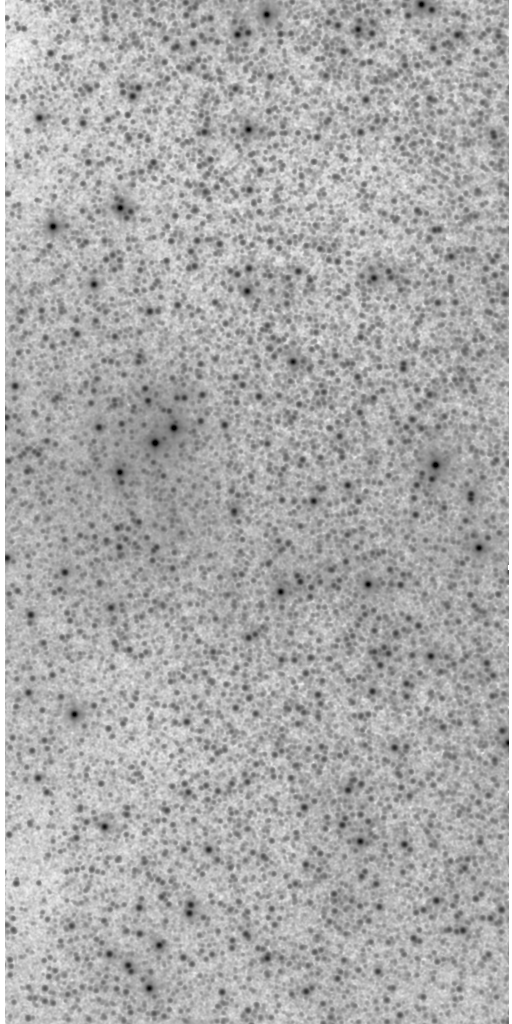

In [3]:
from IPython.display import Image

rtn = mViewer("-ct 1 -gray work/M17/raw/2mass-atlas-990502s-j1340186.fits \
               -2s max gaussian-log -out work/M17/2mass-atlas-990502s-j1340186.png",
              "", mode=2)

Image(filename='work/M17/2mass-atlas-990502s-j1340186.png')


## mArchiveGet Error Handling

If mArchiveGet encounters an error, the return structure will just have two elements: a status of 1 ("error") and a message string that tries to diagnose the reason for the error.

For instance, if the user asks for a URL that doesn't exist:

In [4]:
rtn = mArchiveGet('http://unknown.edu/image/ji1340186.fits.gz', 
                  'work/M17/raw/2mass-atlas-990502s-j1340186.fits')

print(rtn)

{'status': '1', 'msg': b'Unable to resolve URL.'}


<p>&nbsp;</p>

## Classic Montage: mArchiveGet as a Stand-Alone Program


### Unix/Windows Command-line Arguments

<p>mArchiveGet can also be run as a command-line tool in Linux, OS X, and Windows:</p>

<p><tt>
<b>Usage:</b>  mArchiveGet [-d][-t timeout] remoteref localfile
</tt></p>
<p>&nbsp;</p>


## mArchiveGet as a Library Call

If you are writing in C/C++ on Linux or OSX, mArchiveGet can be accessed as a library function:


<pre>
/*-*****************************************************************************/
/*                                                                             */
/* Unfortunately, simple URL access to some archive data has become more       */
/* complex.  It used to be that most data was available via a simple socket    */
/* connection to an HTTP server.  Now many sites use secure sockets (even      */
/* when they don't need to), redirection (often because of the secure sockets) */
/* and so on.                                                                  */
/*                                                                             */
/* We don't want to recreate all the infrastructure in programs like wget      */
/* and curl that deals with all this, so we have opted for using utilities     */
/* like wget or curl.                                                          */
/*                                                                             */
/* Since one or the other of these are default on almost all Linux and OSX     */
/* platforms (though neither is there by default on both platforms), we have   */
/* opted to do the following: First try a fork/exec of wget and parse the      */
/* output string (limited by the -nv flag to be minimal information).  If      */
/* this fails, try the same with curl (limiting the output string here as      */
/* well to just the output file size).  An added twist is that wget sends      */
/* its output to stderr and curl to stdout but we can take care of this        */
/* by being specific about which stream is redirected back to the parent       */
/* process.                                                                    */
/*                                                                             */
/*******************************************************************************/
   
struct mArchiveGetReturn *mArchiveGet(char *url, char *datafile, int timeout, int debug)
</pre>
<p><b>Return Structure</b></p>
<pre>
struct mArchiveGetReturn
{
   int    status;        // Return status (0: OK, 1:ERROR)
   char   msg [1024];    // Return message (for error return)
   char   json[4096];    // Return parameters as JSON string
   int    count;         // Size of the file in bytes
};
</pre>